In [3]:
# https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb

import sys
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
import pytorch_lightning as pl
import timm
import wandb
import torchmetrics
import albumentations as alb
from albumentations.pytorch import ToTensorV2
from PIL import Image
from scipy import ndimage
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy
from optuna_integration import PyTorchLightningPruningCallback

%matplotlib inline
np.random.seed(1)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [4]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [5]:
import dl_utils

In [6]:
# Loading the data (signs)
def get_imgs_labels(h5_file_path):
    f = h5py.File(h5_file_path, "r")
    ds_keys = [key for key in f.keys()]
    imgs = np.array(f[ds_keys[1]])    
    labels = np.array(f[ds_keys[2]])
    list_classes = np.array(f[ds_keys[0]])
    imgs = np.transpose(imgs, (0, 3, 1, 2))
    return imgs, labels, list_classes

train_x, train_y, train_classes = get_imgs_labels("./datasets/train_signs.h5")
test_x, test_y, test_classes = get_imgs_labels("./datasets/test_signs.h5")
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(1080, 3, 64, 64) (1080,)
(120, 3, 64, 64) (120,)


In [7]:
# CONSTANTS
class TransformationType:
    TORCHVISION = "torchvision"
    ALB = "albumentations"

class Models:
    RESNET34 = "resnet34"
    RESNET50 = "resnet50"
    RESNEXT50 = "resnext50_32x4d"

class Config:
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    NUM_CLASSES = 6
    BATCH_SIZE = 64
    NUM_WORKERS = 4
    NUM_EPOCHS = 30
    TRAIN_IMG_MEAN = [0.485, 0.456, 0.406]
    TRAIN_IMG_STD = [0.229, 0.224, 0.225]
    UNFREEZE_EPOCH_NO = 2
    PRECISION = "16-mixed"
    PATIENCE = 6
    LOG_EVERY_N_STEPS = 10
    MODEL_TO_USE = Models.RESNET50
    WEIGHT_DECAY = 1e-6
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    # model hyperparameters
    MODEL_PARAMS = {    
        "drop_out": 0.25,
        "lr": 0.005,
        "warmup_prop": 0.05
    }
    INPUT_IMAGE_SIZE = (64, 64)
    TRANSFORMATION_TYPE = TransformationType.ALB

class SchedulerConfig:
    SCHEDULER_PATIENCE = 3
    SCHEDULER = "ReduceLROnPlateau"
    T_0 = 10 # for CosineAnnealingWarmRestarts
    MIN_LR = 5e-7 # for CosineAnnealingWarmRestarts
    MAX_LR = 1e-2
    STEPS_PER_EPOCH = 13 # for OneCycleLR

class WandbConfig:
    WANDB_KEY = ""
    WANDB_RUN_NAME = "pl_cnn_signs_resnet50"
    WANDB_PROJECT = "pl_cnn_signs"
    USE_WANDB = False    


In [8]:
def config_to_dict(cfg):
    # dir is an inbuilt python function that returns the list of attributes and methods of any object
    return dict((name, getattr(cfg, name)) for name in dir(cfg) if not name.startswith('__'))

In [9]:
config_dict = config_to_dict(Config)
schd_config_dict = config_to_dict(SchedulerConfig)
merged_config_dict = {**config_dict, **schd_config_dict}

In [10]:
# for a training and label data in form of numpy arrays, return a fold_index array whose elements
# represent the fold index. The length of this fold_index array is same as length of input dataset
# and the items for which fold_index array value == cv iteration count are to be used for validation 
# in the corresponding cross validation iteration with rest of the items ( for which fold_index 
# array value != cv iteration count ) being used for training (typical ration being 80:20)
def get_skf_index(num_folds, X, y):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 42)
    train_fold_index = np.zeros(len(y))
    for fold, (train_index, val_index) in enumerate(skf.split(X=X, y=y)):
        train_fold_index[val_index] = [fold + 1] * len(val_index)
    return train_fold_index

k_folds = get_skf_index(num_folds=Config.NUM_FOLDS, X=train_x, y=train_y)

In [11]:
class NpArrayImageDataset(Dataset):
    def __init__(self, img_arr, label_arr, transform, target_transform, 
                transform_type=TransformationType.TORCHVISION):
        self.img_arr = img_arr
        self.label_arr = label_arr
        self.transform = transform
        self.target_transform = target_transform
        self.transform_type = transform_type

    def __len__(self):
        return len(self.label_arr)

    def __getitem__(self, index):
        tfmd_img = self.img_arr[index]
        tfmd_img = tfmd_img.transpose(1,2,0)
        #print(type(tfmd_img), tfmd_img.shape)
        tfmd_label = self.label_arr[index]
        if self.transform:
            if self.transform_type == TransformationType.TORCHVISION:                        
                tfmd_img = self.transform(tfmd_img)
            elif self.transform_type == TransformationType.ALB:
                augmented = self.transform(image=tfmd_img)
                tfmd_img = augmented["image"]                   
        if self.target_transform:               
            tfmd_label = self.target_transform(tfmd_label)              
        return tfmd_img, tfmd_label            

In [12]:
# img_transforms = transforms.Compose([v2.ToTensor(), 
#                                      v2.Normalize(Config.TRAIN_IMG_MEAN, Config.TRAIN_IMG_STD)])

# img_transforms = v2.Compose([#v2.RandomResizedCrop([Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1]]),
#                             v2.RandomHorizontalFlip(p=0.5),
#                             v2.RandomVerticalFlip(p=0.5), 
#                             v2.RandomRotation(45),                                                                         
#                             v2.Normalize(Config.TRAIN_IMG_MEAN, Config.TRAIN_IMG_STD),
#                             v2.ToTensor()])

train_transform = alb.Compose([
        alb.RandomResizedCrop(Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1]),        
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.RandomRotate90(p=0.5),
        alb.Flip(p=0.5),
        alb.Downscale(p=0.25),
        alb.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        alb.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        alb.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        alb.Normalize(mean=Config.TRAIN_IMG_MEAN, std=Config.TRAIN_IMG_STD),
        ToTensorV2()
])

val_transform = alb.Compose([
        alb.CenterCrop(Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1]),
        alb.Normalize(mean=Config.TRAIN_IMG_MEAN, std=Config.TRAIN_IMG_STD),
        ToTensorV2()
])

In [13]:
# Get the train and validation data loaders for a specific fold. 
# X: numpy array of input features
# y: numpy array of target labels
# fold: fold index for which to create data loaders                                     
# kfolds: Array that marks each of the data items as belonging to a specific fold
def get_fold_dls(fold, kfolds, X, y):
    fold += 1                         
    train_X = X[kfolds != fold]        
    train_y = y[kfolds != fold]    
    val_X = X[kfolds == fold]
    val_y = y[kfolds == fold]
    ds_train = NpArrayImageDataset(train_X, train_y, transform=train_transform, 
                                   target_transform=torch.as_tensor, transform_type=Config.TRANSFORMATION_TYPE)
    ds_val = NpArrayImageDataset(val_X, val_y, transform=val_transform, target_transform=torch.as_tensor,
                                 transform_type=Config.TRANSFORMATION_TYPE)
    dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)
    dl_val = DataLoader(ds_val, batch_size=Config.BATCH_SIZE, num_workers=Config.NUM_WORKERS)
    return dl_train, dl_val, ds_train, ds_val

In [14]:
# display images along with their labels from a batch where images are in form of numpy arrays 
# if predictions are provided along with labels, these are displayed too
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(9, 6))
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img, lb = img_ds[img_index]            
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            # the image data has RGB channels at dim 0, the shape of 3, 64, 64 needs to be 64, 64, 3 for display            
            img = img.transpose(1, 2, 0)
            ax.imshow(Image.fromarray(np.uint8(img)).convert('RGB'))        
        if isinstance(lb, torch.Tensor):
            # extract the label from label tensor
            lb = lb.item()            
        title = f"Actual: {lb}"
        if predict_arr: 
            title += f", Pred: {predict_arr[img_index]}"        
        ax.set_title(title)  

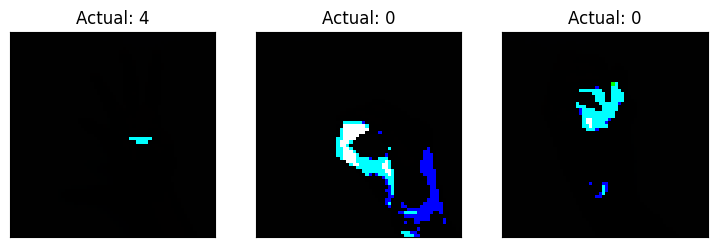

In [15]:
dl_train, dl_val, ds_train, ds_val = get_fold_dls(0, k_folds, train_x, train_y)
show_batch(ds_val, 3, 1, 3)

In [16]:
from torchvision.transforms import v2

class ImageClassificationLitModel(pl.LightningModule):
    def __init__(self, config_dict):
        super().__init__()
        self.save_hyperparameters()
        self.config_dict = config_dict                
        self.num_classes = config_dict["NUM_CLASSES"]
        self.lr = config_dict["MODEL_PARAMS"]["lr"]
        self.cutmix = v2.CutMix(num_classes=config_dict["NUM_CLASSES"])
        self.mixup = v2.MixUp(num_classes=config_dict["NUM_CLASSES"])        
        self.backbone, self.classifier = self.get_backbone_classifier(
            config_dict["MODEL_TO_USE"],
            config_dict["MODEL_PARAMS"]["drop_out"], 
            self.num_classes
        ) 

    @staticmethod
    def get_backbone_classifier(model_to_use, drop_out, num_classes):
        pt_model = timm.create_model(model_to_use, pretrained=True)
        backbone = None
        classifier = None
        if model_to_use in [Models.RESNET34, Models.RESNET50, Models.RESNEXT50]:            
            backbone = nn.Sequential(*list(pt_model.children())[:-1])
            in_features = pt_model.fc.in_features
            classifier = nn.Sequential(
                nn.Dropout(drop_out),
                nn.Linear(in_features, num_classes)
            )    
        return backbone, classifier

    def forward(self, x):
        features = self.backbone(x)
        features = torch.flatten(features, 1)                
        x = self.classifier(features)
        return x

    def configure_optimizers(self):        
        params = self.parameters()
        print(f"len(params) = {len(list(params))}")
        return dl_utils.get_optimizer(lr=self.lr, params=self.parameters(), config_dict=self.config_dict)    
        
    def training_step(self, batch, batch_idx):
        self.cutmix_or_mixup = v2.RandomChoice([self.cutmix, self.mixup])
        X, y = batch
        #print(f"Before CutMix/MixUp: {X.shape = }, {y.shape = }")
        X, y = self.cutmix_or_mixup(X, y)
        #print(f"After CutMix/MixUp: {X.shape = }, {y.shape = }")        
        X, y = batch
        y_pred = self(X)
        loss = cross_entropy(y_pred, y)
        acc = accuracy(y_pred, y, task="multiclass", num_classes=self.num_classes)
        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        val_loss = cross_entropy(y_pred, y)
        val_acc = accuracy(y_pred, y, task="multiclass", num_classes=self.num_classes)
        current_lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("val_acc", val_acc, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("cur_lr", current_lr, prog_bar=True, on_step=True, on_epoch=True, logger=True)
        return {"loss": val_loss, "val_acc": val_acc}

In [17]:
# For results reproducibility 
# sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
pl.seed_everything(Config.RANDOM_SEED, workers=True)

Seed set to 42


42

In [18]:
class OptunaPruning(PyTorchLightningPruningCallback, pl.Callback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

In [19]:
def run_hparam_tuning(model_params, trial):
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(0, k_folds, train_x, train_y)    
    early_stopping = OptunaPruning(trial, monitor="val_loss")
    multiplicative = lambda epoch: 1.5
    backbone_finetuning_cb = BackboneFinetuning(Config.UNFREEZE_EPOCH_NO, multiplicative, verbose=False)
    signs_model = ImageClassificationLitModel(config_dict=merged_config_dict)  
    trainer = pl.Trainer(
        devices="auto",
        accelerator="gpu",
        # For results reproducibility 
        deterministic=True,
        strategy="auto",
        log_every_n_steps=Config.LOG_EVERY_N_STEPS,
        max_epochs=Config.NUM_EPOCHS,        
        precision=Config.PRECISION,   
        enable_model_summary=True,
        enable_progress_bar=True,
        callbacks=[backbone_finetuning_cb, early_stopping]
    )      
    trainer.fit(signs_model, train_dataloaders=dl_train, val_dataloaders=dl_val)     
    loss = trainer.callback_metrics["val_loss"].item()
    del trainer, signs_model, early_stopping, backbone_finetuning_cb, dl_train, dl_val
    return loss

In [20]:
# import optuna

# def objective(trial):
#     params = {
#         "lr": trial.suggest_float("lr", low=1e-6, high=1e-3, log=True),
#         "drop_out": trial.suggest_float("drop_out", low=0.2, high=0.7)
#     }    
#     loss = run_hparam_tuning(params, trial)
#     return loss

# study = optuna.create_study(direction="minimize", study_name="SignsImageClassificationTuning")    
# study.optimize(objective, n_trials=10)
# print(f"Best trial number = {study.best_trial.number}")
# print("Best trial params:")
# print(study.best_params)

In [23]:
import gc
from lightning.pytorch.tuner import Tuner

def run_training(fold, dl_train, dl_val, find_lr=True):
    try:
        fold_str = f"fold{fold}"
        print(f"Running training for {fold_str}")
        logger = None
        if WandbConfig.USE_WANDB:                
            logger = dl_utils.get_wandb_logger(fold, merged_config_dict)
        print("Instantiated wandb logger")    
        chkpt_file_name = "best_model_{epoch}_{val_loss:.4f}"        
        multiplicative = lambda epoch: 1.5
        backbone_finetuning = BackboneFinetuning(Config.UNFREEZE_EPOCH_NO, multiplicative, verbose=True)
        early_stopping_callback = EarlyStopping(monitor="val_loss", patience=Config.PATIENCE, mode="min", verbose=True)
        if fold is not None:       
            chkpt_file_name = fold_str + "_" + chkpt_file_name
        signs_model = ImageClassificationLitModel(config_dict=merged_config_dict)    
        loss_chkpt_callback = ModelCheckpoint(dirpath="./model", verbose=True, monitor="val_loss", mode="min", filename=chkpt_file_name)
        acc_chkpt_callback = dl_utils.MetricsAggCallback(metric_to_monitor="val_acc", mode="max")
        trainer = pl.Trainer(
            devices="auto",
            accelerator="gpu",
            # For results reproducibility 
            deterministic=True,
            strategy="auto",
            log_every_n_steps=Config.LOG_EVERY_N_STEPS,
            max_epochs=Config.NUM_EPOCHS,        
            precision=Config.PRECISION,   
            enable_model_summary=True,
            enable_progress_bar=True,                        
            logger=logger,            
            callbacks=[loss_chkpt_callback, acc_chkpt_callback, backbone_finetuning, early_stopping_callback]
        )
        tuner = Tuner(trainer)
        
        if find_lr:
            lr_finder = tuner.lr_find(model=signs_model, train_dataloaders=dl_train)
            # Results can be found in
            print(lr_finder.results)
            # Results can be plotted to identify the optimal learning rate
            fig = lr_finder.plot(suggest=True)
            fig.show()
            # Pick the suggested learning rate
            new_lr = lr_finder.suggestion()
            print(f"new_lr = {new_lr}")

        trainer.fit(signs_model, train_dataloaders=dl_train, val_dataloaders=dl_val)                
        loss = loss_chkpt_callback.best_model_score.cpu().detach().item()
        acc = acc_chkpt_callback.best_metric
        print(f"Loss for {fold_str} = {loss}, accuracy = {acc}")
        del trainer, tuner, signs_model, backbone_finetuning, early_stopping_callback, acc_chkpt_callback, loss_chkpt_callback                 
        return loss, acc
    except KeyboardInterrupt as e:
        wandb.finish(exit_code=-1, quiet=True)
        print("Marked the wandb run as failed")
    finally:
        gc.collect()
        torch.cuda.empty_cache()
        wandb.finish()

In [24]:
find_lr = True
fold_loss = []
fold_acc = []

for fold in range(Config.NUM_FOLDS):
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(fold, k_folds, train_x, train_y)
    loss, acc = run_training(fold, dl_train, dl_val, find_lr=False)
    fold_loss.append(loss)
    fold_acc.append(acc)
    break
     

Running training for fold0
Instantiated wandb logger


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
/home/bk_anupam/anaconda3/envs/ml_env/lib/python3.11/site-packages/pytorch_lightning/plugins/precision/amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/

len(params) = 161
param groups count = 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

epoch = 1 => metric val_acc = 0.1640625, val_loss=1.8243789672851562, lr=0.004999999888241291


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 1.150
INFO: Epoch 0, global step 14: 'val_loss' reached 1.14977 (best 1.14977), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=0_val_loss=1.1498.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 14: 'val_loss' reached 1.14977 (best 1.14977), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=0_val_loss=1.1498.ckpt' as top 1


epoch = 2 => metric val_acc = 0.5833333134651184, val_loss=1.1497708559036255, lr=0.004999999422580004


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.241 >= min_delta = 0.0. New best score: 0.909
INFO: Epoch 1, global step 28: 'val_loss' reached 0.90857 (best 0.90857), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=1_val_loss=0.9086.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 28: 'val_loss' reached 0.90857 (best 0.90857), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=1_val_loss=0.9086.ckpt' as top 1


epoch = 3 => metric val_acc = 0.6574074029922485, val_loss=0.9085701704025269, lr=0.004999999422580004


/home/bk_anupam/anaconda3/envs/ml_env/lib/python3.11/site-packages/pytorch_lightning/callbacks/finetuning.py:238: The provided params to be frozen already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
Current lr: 0.005, Backbone lr: 0.0005


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 42: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 42: 'val_loss' was not in top 1
Current lr: 0.005, Backbone lr: 0.00075


epoch = 4 => metric val_acc = 0.23148147761821747, val_loss=3.267014980316162, lr=0.004999999422580004


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.881
INFO: Epoch 3, global step 56: 'val_loss' reached 0.88137 (best 0.88137), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=3_val_loss=0.8814.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 56: 'val_loss' reached 0.88137 (best 0.88137), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=3_val_loss=0.8814.ckpt' as top 1


epoch = 5 => metric val_acc = 0.6435185074806213, val_loss=0.8813731670379639, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.237 >= min_delta = 0.0. New best score: 0.645
INFO: Epoch 4, global step 70: 'val_loss' reached 0.64453 (best 0.64453), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=4_val_loss=0.6445.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 70: 'val_loss' reached 0.64453 (best 0.64453), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=4_val_loss=0.6445.ckpt' as top 1


epoch = 6 => metric val_acc = 0.7453703880310059, val_loss=0.6445304751396179, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 0.571
INFO: Epoch 5, global step 84: 'val_loss' reached 0.57100 (best 0.57100), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=5_val_loss=0.5710.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 84: 'val_loss' reached 0.57100 (best 0.57100), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=5_val_loss=0.5710.ckpt' as top 1


epoch = 7 => metric val_acc = 0.7361111044883728, val_loss=0.5709969401359558, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.201 >= min_delta = 0.0. New best score: 0.370
INFO: Epoch 6, global step 98: 'val_loss' reached 0.37027 (best 0.37027), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=6_val_loss=0.3703.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 98: 'val_loss' reached 0.37027 (best 0.37027), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=6_val_loss=0.3703.ckpt' as top 1


epoch = 8 => metric val_acc = 0.8703703880310059, val_loss=0.3702690601348877, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.093 >= min_delta = 0.0. New best score: 0.277
INFO: Epoch 7, global step 112: 'val_loss' reached 0.27686 (best 0.27686), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=7_val_loss=0.2769.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 112: 'val_loss' reached 0.27686 (best 0.27686), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=7_val_loss=0.2769.ckpt' as top 1


epoch = 9 => metric val_acc = 0.9027777910232544, val_loss=0.2768634855747223, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.222
INFO: Epoch 8, global step 126: 'val_loss' reached 0.22211 (best 0.22211), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=8_val_loss=0.2221.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 126: 'val_loss' reached 0.22211 (best 0.22211), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=8_val_loss=0.2221.ckpt' as top 1


epoch = 10 => metric val_acc = 0.9305555820465088, val_loss=0.22211343050003052, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 140: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 140: 'val_loss' was not in top 1
Current lr: 0.00075, Backbone lr: 0.00075


epoch = 11 => metric val_acc = 0.9166666865348816, val_loss=0.23783019185066223, lr=0.000750000006519258


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 154: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 154: 'val_loss' was not in top 1
Current lr: 0.00075, Backbone lr: 0.00075


epoch = 12 => metric val_acc = 0.9305555820465088, val_loss=0.2278435379266739, lr=0.000750000006519258


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 168: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 168: 'val_loss' was not in top 1
Current lr: 0.00075, Backbone lr: 0.00075


epoch = 13 => metric val_acc = 0.8935185074806213, val_loss=0.2976182997226715, lr=0.000750000006519258


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 182: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 182: 'val_loss' was not in top 1
Current lr: 7.5e-05, Backbone lr: 7.5e-05


epoch = 14 => metric val_acc = 0.8611111044883728, val_loss=0.36914464831352234, lr=0.000750000006519258


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 196: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 196: 'val_loss' was not in top 1
Current lr: 7.5e-05, Backbone lr: 7.5e-05


epoch = 15 => metric val_acc = 0.9259259104728699, val_loss=0.22568638622760773, lr=7.500000356230885e-05


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.168
INFO: Epoch 14, global step 210: 'val_loss' reached 0.16765 (best 0.16765), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=14_val_loss=0.1676.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 210: 'val_loss' reached 0.16765 (best 0.16765), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=14_val_loss=0.1676.ckpt' as top 1


epoch = 16 => metric val_acc = 0.9629629850387573, val_loss=0.16764695942401886, lr=7.500000356230885e-05


Current lr: 7.5e-05, Backbone lr: 7.5e-05


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.153
INFO: Epoch 15, global step 224: 'val_loss' reached 0.15299 (best 0.15299), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=15_val_loss=0.1530.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 224: 'val_loss' reached 0.15299 (best 0.15299), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=15_val_loss=0.1530.ckpt' as top 1


epoch = 17 => metric val_acc = 0.9675925970077515, val_loss=0.1529911905527115, lr=7.500000356230885e-05


Current lr: 7.5e-05, Backbone lr: 7.5e-05


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.146
INFO: Epoch 16, global step 238: 'val_loss' reached 0.14631 (best 0.14631), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=16_val_loss=0.1463.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 238: 'val_loss' reached 0.14631 (best 0.14631), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=16_val_loss=0.1463.ckpt' as top 1


epoch = 18 => metric val_acc = 0.9675925970077515, val_loss=0.14630864560604095, lr=7.500000356230885e-05


Current lr: 7.5e-05, Backbone lr: 7.5e-05


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.138
INFO: Epoch 17, global step 252: 'val_loss' reached 0.13821 (best 0.13821), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=17_val_loss=0.1382.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 252: 'val_loss' reached 0.13821 (best 0.13821), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=17_val_loss=0.1382.ckpt' as top 1


epoch = 19 => metric val_acc = 0.9629629850387573, val_loss=0.1382102370262146, lr=7.500000356230885e-05


Current lr: 7.5e-05, Backbone lr: 7.5e-05


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 18, global step 266: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 266: 'val_loss' was not in top 1
Current lr: 7.5e-05, Backbone lr: 7.5e-05


epoch = 20 => metric val_acc = 0.9629629850387573, val_loss=0.14297567307949066, lr=7.500000356230885e-05


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 19, global step 280: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 280: 'val_loss' was not in top 1
Current lr: 7.5e-05, Backbone lr: 7.5e-05


epoch = 21 => metric val_acc = 0.9675925970077515, val_loss=0.14524562656879425, lr=7.500000356230885e-05


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 20, global step 294: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 294: 'val_loss' was not in top 1
Current lr: 7.5e-05, Backbone lr: 7.5e-05


epoch = 22 => metric val_acc = 0.9722222089767456, val_loss=0.14123548567295074, lr=7.500000356230885e-05


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.137
INFO: Epoch 21, global step 308: 'val_loss' reached 0.13713 (best 0.13713), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=21_val_loss=0.1371.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 21, global step 308: 'val_loss' reached 0.13713 (best 0.13713), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=21_val_loss=0.1371.ckpt' as top 1


epoch = 23 => metric val_acc = 0.9629629850387573, val_loss=0.137130469083786, lr=7.500000356230885e-05


Current lr: 7.5e-05, Backbone lr: 7.5e-05


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.132
INFO: Epoch 22, global step 322: 'val_loss' reached 0.13231 (best 0.13231), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=22_val_loss=0.1323.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 22, global step 322: 'val_loss' reached 0.13231 (best 0.13231), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=22_val_loss=0.1323.ckpt' as top 1


epoch = 24 => metric val_acc = 0.9675925970077515, val_loss=0.13230565190315247, lr=7.500000356230885e-05


Current lr: 7.5e-05, Backbone lr: 7.5e-05


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 23, global step 336: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 23, global step 336: 'val_loss' was not in top 1
Current lr: 7.5e-05, Backbone lr: 7.5e-05


epoch = 25 => metric val_acc = 0.9629629850387573, val_loss=0.13783852756023407, lr=7.500000356230885e-05


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 24, global step 350: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 24, global step 350: 'val_loss' was not in top 1
Current lr: 7.5e-05, Backbone lr: 7.5e-05


epoch = 26 => metric val_acc = 0.9583333134651184, val_loss=0.137502059340477, lr=7.500000356230885e-05


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.125
INFO: Epoch 25, global step 364: 'val_loss' reached 0.12537 (best 0.12537), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=25_val_loss=0.1254.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 25, global step 364: 'val_loss' reached 0.12537 (best 0.12537), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=25_val_loss=0.1254.ckpt' as top 1


epoch = 27 => metric val_acc = 0.9537037014961243, val_loss=0.1253703087568283, lr=7.500000356230885e-05


Current lr: 7.5e-05, Backbone lr: 7.5e-05


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 26, global step 378: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 26, global step 378: 'val_loss' was not in top 1
Current lr: 7.5e-05, Backbone lr: 7.5e-05


epoch = 28 => metric val_acc = 0.9583333134651184, val_loss=0.12808692455291748, lr=7.500000356230885e-05


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 27, global step 392: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 27, global step 392: 'val_loss' was not in top 1
Current lr: 7.5e-05, Backbone lr: 7.5e-05


epoch = 29 => metric val_acc = 0.9490740895271301, val_loss=0.12707674503326416, lr=7.500000356230885e-05


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.119
INFO: Epoch 28, global step 406: 'val_loss' reached 0.11853 (best 0.11853), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=28_val_loss=0.1185.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 28, global step 406: 'val_loss' reached 0.11853 (best 0.11853), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=28_val_loss=0.1185.ckpt' as top 1


epoch = 30 => metric val_acc = 0.9629629850387573, val_loss=0.11853355914354324, lr=7.500000356230885e-05


Current lr: 7.5e-05, Backbone lr: 7.5e-05


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 29, global step 420: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 29, global step 420: 'val_loss' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


epoch = 31 => metric val_acc = 0.9537037014961243, val_loss=0.12030928581953049, lr=7.500000356230885e-05
Loss for fold0 = 0.11853355914354324, accuracy = 0.9722222089767456


In [25]:
import statistics

print("Loss across folds")
print(fold_loss)
print("Accuracy across folds")
print(fold_acc)

if len(fold_loss) > 1:
    mean_loss = statistics.mean(fold_loss)
    mean_acc = statistics.mean(fold_acc)
    std_loss = statistics.stdev(fold_loss)
    std_acc = statistics.stddev(fold_acc)
    print(f"mean loss across folds = {mean_loss}, loss stdev across fold = {std_loss}")
    print(f"mean accuracy across folds = {mean_acc}, accuracy stdev across fold = {std_acc}")

Loss across folds
[0.11853355914354324]
Accuracy across folds
[0.9722222089767456]


In [26]:
test_transform = alb.Compose([
        alb.CenterCrop(Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1]),
        alb.Normalize(mean=Config.TRAIN_IMG_MEAN, std=Config.TRAIN_IMG_STD),
        ToTensorV2()
])

In [27]:
ds_test = NpArrayImageDataset(test_x, test_y, transform=test_transform, target_transform=torch.as_tensor, 
                              transform_type=Config.TRANSFORMATION_TYPE)
dl_test = DataLoader(ds_test, batch_size=Config.BATCH_SIZE, num_workers=Config.NUM_WORKERS)

In [29]:
import tqdm

model = ImageClassificationLitModel.load_from_checkpoint(
    checkpoint_path="model/fold0_best_model_epoch=28_val_loss=0.1185.ckpt",     
    num_classes=Config.NUM_CLASSES
    )
model.to("cuda")
model.eval()

incorrect = 0
total = 0
predicted_labels_incorrect = []
labels_incorrect = []
with torch.no_grad():
    counter=0
    for imgs, labels in tqdm.tqdm(dl_test):                
        predicted_cuda_labels = torch.argmax(model(imgs.to("cuda")), dim=1)
        predicted_labels = predicted_cuda_labels.detach().cpu()
        total += labels.shape[0]
        correct_pred = predicted_labels == labels
        incorrect_pred = ~correct_pred
        num_incorrect_pred = incorrect_pred.sum()
        incorrect += int(num_incorrect_pred)
        if num_incorrect_pred > 0:
            predicted_labels_incorrect.append(predicted_labels[incorrect_pred].numpy())
            labels_incorrect.append(labels[incorrect_pred].numpy())
print(f'Total no. of images in test set: {total}')
print(f'Incorrectly classified images in test set: {incorrect}')
accuracy = ((total-incorrect) / total) * 100        
print(f"Accuracy: {accuracy}%")

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

Total no. of images in test set: 120
Incorrectly classified images in test set: 3
Accuracy: 97.5%
